## Funkcje pomocnicze

### Niezbędne biblioteki

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
import os
import sys
import glob
import random

from pprint import pprint
from ipywidgets import Video

from PIL import Image
from PIL.ExifTags import TAGS

from sklearn.cluster import KMeans

### Zbiór danych

In [2]:
!pip install --upgrade --no-cache-dir gdown
!gdown https://drive.google.com/uc?id=1OjFFysQD-MbhiTzfesrvXqkIg6oNRIyK&confirm=t

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1OjFFysQD-MbhiTzfesrvXqkIg6oNRIyK
To: /content/roonie_snooker.mp4
100% 6.24M/6.24M [00:00<00:00, 71.3MB/s]


### Wizualizacja

In [3]:
def imshow(a):
  a = a.clip(0, 255).astype('uint8')
  if a.ndim == 3:
    if a.shape[2] == 4:
      a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
    else:
      a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
  display(PIL.Image.fromarray(a))

In [4]:
def open_video(path):
  video = cv2.VideoCapture(path)
  if not video.isOpened():
      print("[ERROR]: Could not open video from the given path.")

  video_width = int(video.get(3))
  video_height = int(video.get(4))
  video_fps = video.get(cv2.CAP_PROP_FPS)
  print(f"Video: width={video_width} height={video_height} fps={video_fps}")

  return video, video_width, video_height, video_fps

## Pozyskanie pierwszej klatki video

Video: width=1280 height=720 fps=25.0


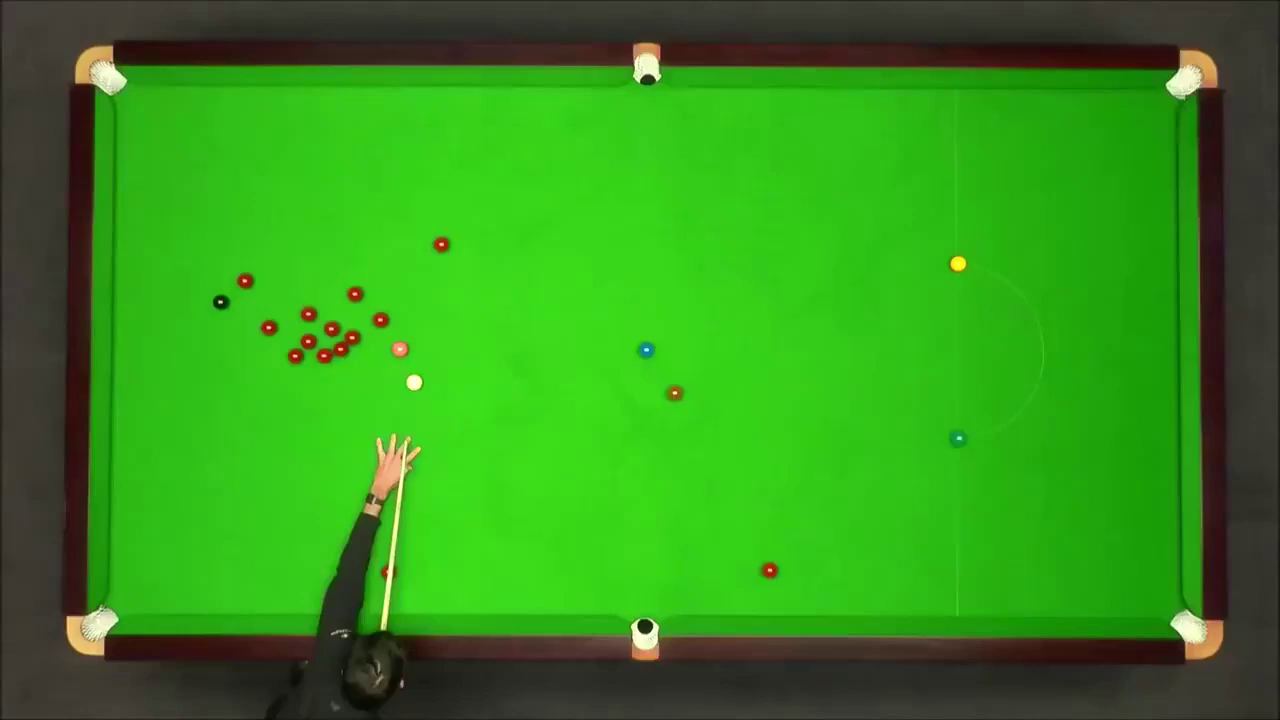

In [5]:
video, video_width, video_height, video_fps = open_video("./roonie_snooker.mp4")

# setup
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, first_frame = video.read()

imshow(first_frame)

## Detekcja stołu

In [6]:
def detect_edges(frame):
  gray_f = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  threshold_f = cv2.adaptiveThreshold(gray_f, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, -12)
  lines = cv2.HoughLinesP(threshold_f, rho=2, theta=np.pi/20, threshold=600, minLineLength=400, maxLineGap=50)
  return lines


def detect_edge_intersection(lines, tolerance=0.1):
  def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
      return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
      raise Exception('Determinant equals zero.')

    d = (det(*line1), det(*line2))
    x = int(det(d, xdiff) / div)
    y = int(det(d, ydiff) / div)
    return x, y
  
  intersection_points = []
  for line1 in lines:
    x1, y1, x2, y2 = line1[0]
    for line2 in lines:
      x3,y3,x4,y4 = line2[0]
      m1 = abs((y2 - y1) / (x2 - x1))
      m2 = abs((y4 - y3) / (x4 - x3))
      if abs(m1 - m2) > tolerance:
        intersection_point = line_intersection(((x1, y1), (x2, y2)), ((x3, y3), (x4, y4)))
        intersection_points.append(intersection_point)
  return intersection_points


def detect_table_corners(intersection_points, n_clusters=4):
  # remove intersection points from the top of the frame
  for intersection_point in intersection_points:
    _, y = intersection_point
    if y < 10:
      intersection_points.remove(intersection_point)

  # perform k-means to detect table corners
  intersection_points = np.asarray(intersection_points).astype(np.float32)
  model = KMeans(n_clusters=n_clusters, n_init=10)
  model.fit(intersection_points)
  segments = model.predict(intersection_points)
  corners = np.stack([intersection_points[segments==i].mean(0) for i in range(n_clusters)], 0)

  return corners.astype(int)


def detect_table_borders(frame, tolerance=2, get_steps=False):
  table_borders = []
  # detect edges
  lines = detect_edges(frame)
  # detect edge intersection
  intersection_points = detect_edge_intersection(lines)
  # detect table corners
  corners = detect_table_corners(intersection_points)

  for corner1 in corners:
    for corner2 in corners:
      if any(corner1 != corner2) and (abs(corner1[0] - corner2[0]) < tolerance or abs(corner1[1] - corner2[1]) < tolerance):
        table_borders.append((corner1, corner2))
  
  if get_steps:
    return corners, table_borders

  return table_borders


def make_table_borders(frame, table_borders):
  for corner1, corner2 in table_borders:
    cv2.line(frame, corner1, corner2, (255, 0, 0), 5)


def sort_corners(corners):
  sums = {}
  for index, corner in enumerate(corners):
    sums[index] = corner[0] + corner[1]
  sums = sorted(sums.items(), key=lambda x:x[1])
  sorted_corners = np.array([corners[s[0]] for s in sums])
  tmp = sorted_corners[3].copy()
  sorted_corners[3] = sorted_corners[2]
  sorted_corners[2] = tmp
  return sorted_corners


def make_table_mask(frame, corners):
  gray_f = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  threshold_f = cv2.adaptiveThreshold(gray_f, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 19, -12)
  table_mask = np.zeros_like(threshold_f)
  table_mask = table_mask + 255
  sorted_corners = sort_corners(table_corners)
  table_mask = cv2.fillConvexPoly(table_mask, sorted_corners, 1)
  return table_mask

<ipython-input-6-c498cedf668b>:31: RuntimeWarning: divide by zero encountered in int_scalars
  m2 = abs((y4 - y3) / (x4 - x3))
<ipython-input-6-c498cedf668b>:30: RuntimeWarning: divide by zero encountered in int_scalars
  m1 = abs((y2 - y1) / (x2 - x1))
<ipython-input-6-c498cedf668b>:32: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m1 - m2) > tolerance:


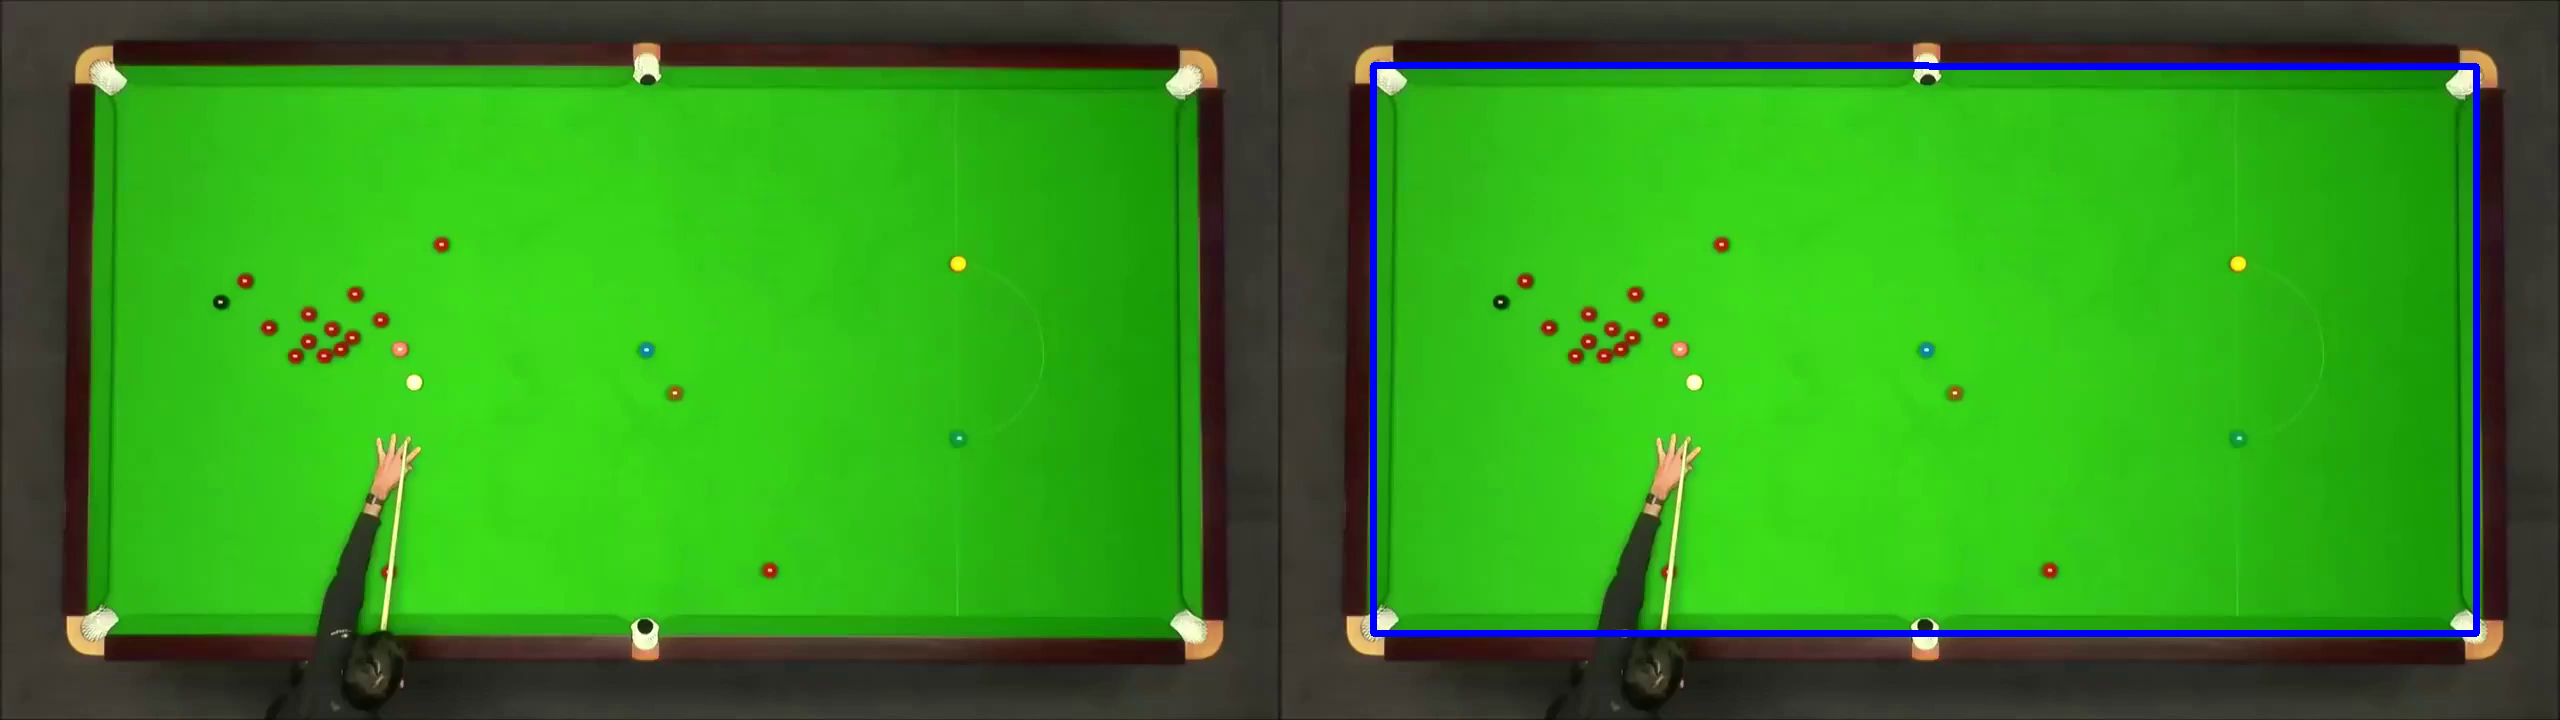

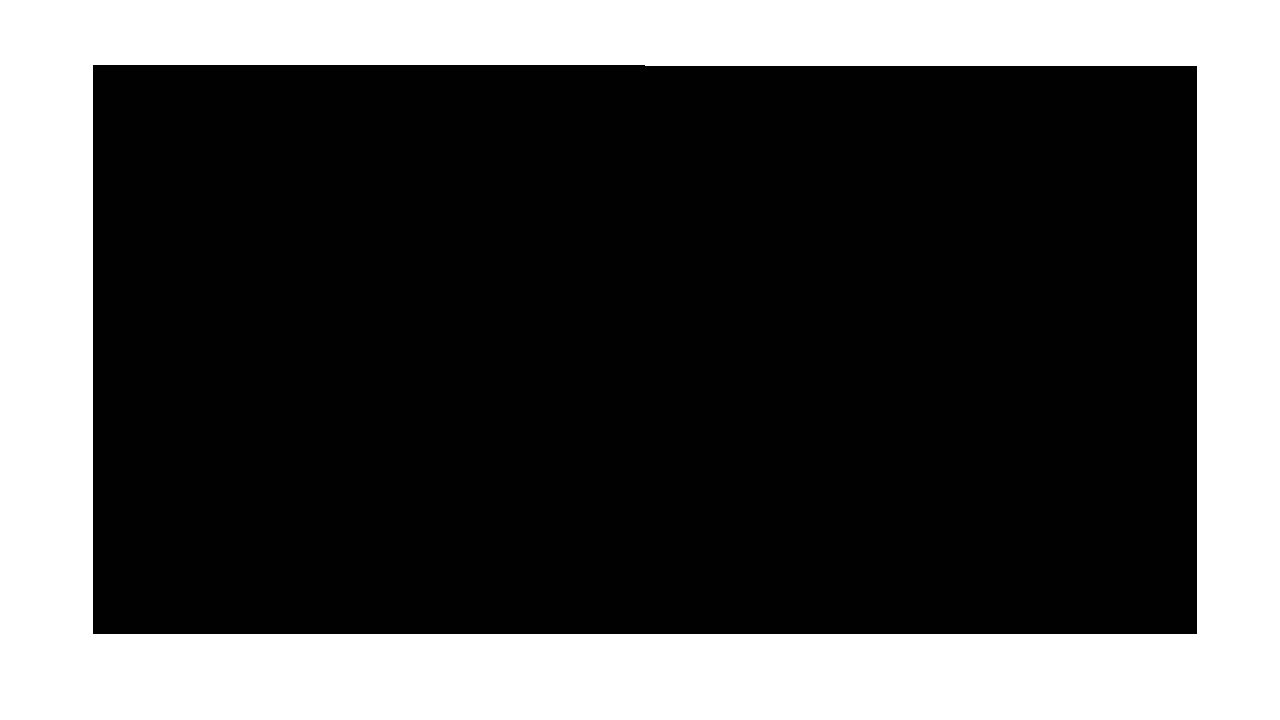

In [7]:
frame_with_detected_table = first_frame.copy()
table_corners, table_borders = detect_table_borders(frame_with_detected_table, get_steps=True)
make_table_borders(frame_with_detected_table, table_borders)

frame_copy = first_frame.copy()
table_mask = make_table_mask(frame_copy, table_corners)


imshow(np.concatenate([first_frame, frame_with_detected_table], 1))
imshow(table_mask)

## Detekcja bil

In [7]:
...

## Detekcja gry w bilarda na video

In [8]:
# video drawing
def draw_table_borders(video_track, frame, table_borders):
  for corner1, corner2 in table_borders:
    video_track.write(cv2.line(frame, corner1, corner2, (255, 0, 0), 5))

In [9]:
video, video_width, video_height, video_fps = open_video("./roonie_snooker.mp4")

video_track = cv2.VideoWriter('./roonie_snooker.avi', cv2.VideoWriter_fourcc(*'DIVX'), video_fps, (video_width, video_height))

# setup
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
ret, frame = video.read()

# get table borders
table_borders = detect_table_borders(frame) if ret else []

Video: width=1280 height=720 fps=25.0


<ipython-input-6-c498cedf668b>:31: RuntimeWarning: divide by zero encountered in int_scalars
  m2 = abs((y4 - y3) / (x4 - x3))
<ipython-input-6-c498cedf668b>:30: RuntimeWarning: divide by zero encountered in int_scalars
  m1 = abs((y2 - y1) / (x2 - x1))
<ipython-input-6-c498cedf668b>:32: RuntimeWarning: invalid value encountered in double_scalars
  if abs(m1 - m2) > tolerance:


In [10]:
# video loop
video.set(cv2.CAP_PROP_POS_FRAMES, 0)
for _ in range(100):
    ret, frame = video.read()

    if ret:
      draw_table_borders(video_track, frame, table_borders)
    else:
        break

video_track.release()

In [11]:
!ffmpeg -hide_banner -loglevel error -i roonie_snooker.avi -y roonie_snooker.mp4
Video.from_file('./roonie_snooker.mp4')

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\t\x89Amdat\x00\x00…